<a href="https://colab.research.google.com/github/Tanyafain123/67547-project-template/blob/main/Cognitive_AI_coursework_code%2C_final_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
%%capture
# @title Generating dataset from a perceptual decision making task
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import neurogym as ngym
import matplotlib.pyplot as plt
import scipy.spatial


--- Training Brain Inspired AI Model on ContextDecisionMaking-v0 ---
Accuracy: 0.0206
Epoch 1, Loss: 1.2498, Accuracy: 0.0206
Accuracy: 0.0269
Epoch 11, Loss: 1.1948, Accuracy: 0.0269
Accuracy: 0.9506
Epoch 21, Loss: 1.1438, Accuracy: 0.9506
Accuracy: 0.9487
Epoch 31, Loss: 1.0917, Accuracy: 0.9487
Accuracy: 0.9481
Epoch 41, Loss: 1.0353, Accuracy: 0.9481
Accuracy: 0.9563
Epoch 51, Loss: 0.9771, Accuracy: 0.9563
Accuracy: 0.9450
Epoch 61, Loss: 0.9080, Accuracy: 0.9450
Accuracy: 0.9513
Epoch 71, Loss: 0.8583, Accuracy: 0.9513
Accuracy: 0.9506
Epoch 81, Loss: 0.8172, Accuracy: 0.9506
Accuracy: 0.9563
Epoch 91, Loss: 0.7886, Accuracy: 0.9563


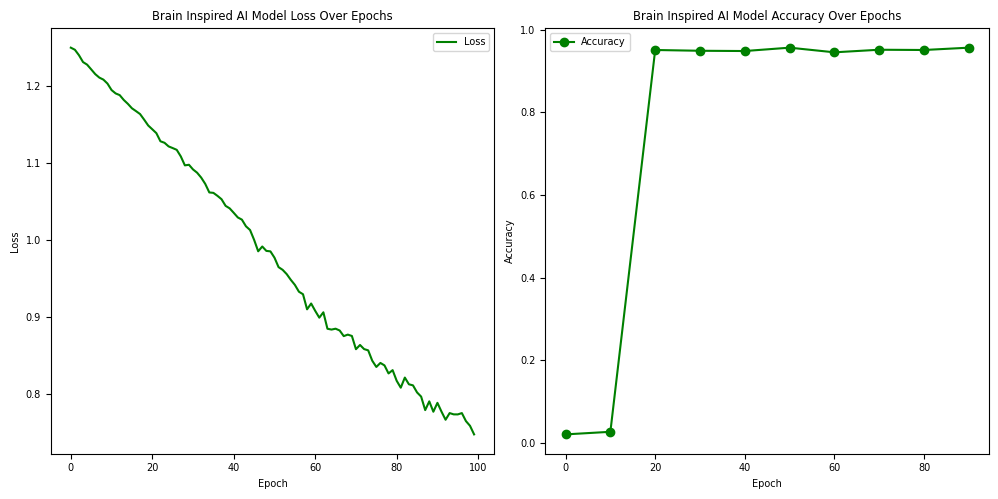


--- Final Results for Brain Inspired AI Model on ContextDecisionMaking-v0 ---
Final Loss: 0.7476
Final Accuracy: 0.9563

--- Training LSTM on ContextDecisionMaking-v0 ---
Training network...
Accuracy: 0.9556
Epoch 1, Loss: 1.1214, Accuracy: 0.9556
Accuracy: 0.9494
Epoch 11, Loss: 0.2016, Accuracy: 0.9494
Accuracy: 0.9550
Epoch 21, Loss: 0.2464, Accuracy: 0.9550
Accuracy: 0.9494
Epoch 31, Loss: 0.2276, Accuracy: 0.9494
Accuracy: 0.9456
Epoch 41, Loss: 0.1392, Accuracy: 0.9456
Accuracy: 0.9525
Epoch 51, Loss: 0.1360, Accuracy: 0.9525
Accuracy: 0.9437
Epoch 61, Loss: 0.1145, Accuracy: 0.9437
Accuracy: 0.9700
Epoch 71, Loss: 0.0830, Accuracy: 0.9700


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import neurogym as ngym
import matplotlib.pyplot as plt
import time
import scipy.spatial
from torch.nn import init
from torch.nn import functional as F
import math


plt.rcParams['font.family'] = 'DejaVu Sans'




########## MODELS IMPLEMENTATION ##########

##### BRAIN INSPIRED MODEL IMPLEMENTATION #####


# Spatial Regularizer
class Reg_WD(nn.Module):
        """
    A spatial regularizer for RNNs.

    This class computes a regularization loss based on the spatial distance
    between neurons to encourage biologically plausible connectivity.

    """
        def __init__(self, reg_WD=0.01, neuron_num=100, network_structure=(5, 5, 4), coordinates_list=None, distance_power=1, distance_metric='euclidean'):
          super(Reg_WD, self).__init__()
          self.distance_power = distance_power
          self.reg_WD = torch.tensor([reg_WD], dtype=torch.float32)

          # Set up tensor with distance matrix
          nx = np.arange(network_structure[0])
          ny = np.arange(network_structure[1])
          nz = np.arange(network_structure[2])
          x, y, z = np.meshgrid(nx, ny, nz)
          self.coordinates = [x.ravel(), y.ravel(), z.ravel()]

          # Override coordinate grid if provided in init
          if coordinates_list is not None:
              self.coordinates = coordinates_list

          # Calculate the Euclidean distance matrix
          euclidean_vector = scipy.spatial.distance.pdist(np.transpose(self.coordinates), metric=distance_metric)
          euclidean = scipy.spatial.distance.squareform(euclidean_vector ** self.distance_power)
          self.distance_matrix = torch.tensor(euclidean, dtype=torch.float32)

        def forward(self, recurrent_weights):
            abs_weight_matrix = torch.abs(recurrent_weights)
            WD_loss = self.reg_WD * torch.sum(abs_weight_matrix * self.distance_matrix)
            return WD_loss


class EIRecLinear(nn.Module):

    r"""Recurrent E-I Linear transformation.

    This module implements a linear transformation with recurrent E-I dynamics,
    where part of the units are excitatory and the rest are inhibitory.

    Args:
        hidden_size: int, the number of units in the layer.
        e_prop: float between 0 and 1, the proportion of excitatory units.
        bias: bool, if True, adds a learnable bias to the output.
    """

    __constants__ = ['bias', 'hidden_size', 'e_prop']

    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size)
        self.i_size = hidden_size - self.e_size
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        mask_no_diag = np.ones((hidden_size, hidden_size)) - np.eye(hidden_size)
        D = torch.ones(hidden_size)
        D = torch.diag(D)


        mask_no_diag = np.ones((self.hidden_size,self.hidden_size)) -  np.diag(np.ones((self.hidden_size)))

        E_I_unit_list = np.concatenate((np.ones((self.e_size,1)),-1*np.ones((self.i_size,1)))).T

        mask = mask_no_diag*E_I_unit_list

        self.mask = torch.tensor(mask, dtype=torch.float32)


        # Optionally add a bias term
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights and biases
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # Scale the weights for the excitatory neurons
        self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)

        # Initialize biases
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def effective_weight(self):
        # Apply the mask you have already created to the weights after applying rectification to get the effective weight
        # This ensures that weights from excitatory neurons are positive,
        # and weights from inhibitory neurons are negative.
        eff_W = F.relu(self.weight)* self.mask
        return eff_W

    def forward(self, input):
        # Apply the linear transformation using the effective weights and biases
        # The weights used are non-negative due to the absolute value in effective_weight.
        return F.linear(input, self.effective_weight(), self.bias)

    def create_mask(self):
        # Start with a zero matrix for the mask
        mask = np.zeros((self.hidden_size, self.hidden_size))

        # Set the first e_size rows (excitatory) to 1 (positive weights)
        mask[:self.e_size, :] = 1  # Excitatory neurons have positive outgoing connections

        # Set the remaining i_size rows (inhibitory) to -1 (negative weights)
        mask[self.e_size:, :] = -1  # Inhibitory neurons have negative outgoing connections

        # Remove self-connections by setting the diagonal to 0
        np.fill_diagonal(mask, 0)

        # Convert the mask to a tensor for PyTorch operations
        return torch.tensor(mask, dtype=torch.float32)


class BrainInspiredAIModel(nn.Module):
    """
    A Leaky Excitatory-Inhibitory RNN with E-I dynamics.
    """
    def __init__(self, input_size, hidden_size, dt=None, e_prop=0.8, sigma_rec=0, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100

        if dt is None:
            self.alpha = 1
        else:
            self.alpha = dt / self.tau
        self.oneminusalpha = 1 - self.alpha

        self._sigma_rec = np.sqrt(2 * self.alpha) * sigma_rec

        self.Wxh = nn.Parameter(torch.randn(hidden_size, input_size) * 0.01)  # Input to hidden

        self.h2h = EIRecLinear(hidden_size, e_prop)  # Recurrent weights with E-I masking

        self.bh = nn.Parameter(torch.zeros(hidden_size))  # Bias vector

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

    def forward(self, inputs):
        seq_len, batch_size, _ = inputs.size()
        hidden = self.init_hidden(batch_size).to(inputs.device)
        self.inputs = []
        self.hiddens = [hidden]

        outputs = []
        for t in range(seq_len):
            input_t = inputs[t]
            self.inputs.append(input_t)

            recurrent_contribution = self.h2h(hidden)  # Apply E-I masked recurrent weights
            pre_activation = self.Wxh @ input_t.T + recurrent_contribution.T + self.bh[:, None]
            pre_activation = pre_activation.T

            # Leaky integration
            hidden = (1 - self.alpha) * hidden + self.alpha * torch.tanh(pre_activation)

            # Add noise to recurrent dynamics
            if self._sigma_rec > 0:
                hidden += self._sigma_rec * torch.randn_like(hidden)

            self.hiddens.append(hidden)
            outputs.append(hidden)

        outputs = torch.stack(outputs)
        return outputs



class Net(nn.Module):
  """
    Neural network with a BrainInspiredAIModel and an output layer.
    """
  def __init__(self, input_size, hidden_size, output_size, **kwargs):
      super().__init__()
      self.rnn = BrainInspiredAIModel(input_size, hidden_size, **kwargs)
      self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
      rnn_output = self.rnn(x)
      out = self.fc(rnn_output)
      return out



##### REGULAR AI MODEL IMPLEMENTATION #####

class RNNNet(nn.Module):
    """
    Recurrent network model based on LSTM.
    Methods:
        forward(x):
            Propagates inputs through the LSTM and output layers.
    """
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, **kwargs):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)# Add an output layer

    def forward(self, x):
        rnn_output, _ = self.lstm(x)
        out = self.fc(rnn_output)
        return out, rnn_output


########## TRAINING AND EVALUATION ##########

def bptt_feedback_alignment(net, outputs, targets, regularizer):
    """
    Computes weight updates for a recurrent neural network (RNN)
    using a biologically plausible feedback alignment approach
    """
    seq_len, batch_size, output_size = outputs.size()

    random_feedback_output = torch.randn(output_size, net.rnn.hidden_size, device=outputs.device)# Initialize random feedback matrices for output and recurrent layers

    random_feedback_recurrent = torch.randn(net.rnn.hidden_size, net.rnn.hidden_size, device=outputs.device)# Initialize random feedback matrices for recurrent layers


    # Initialize gradients
    dWxh = torch.zeros_like(net.rnn.Wxh)  # Input-to-hidden
    dWhh = torch.zeros_like(net.rnn.h2h.weight)  # Gradients for the raw recurrent weights
    dbh = torch.zeros_like(net.rnn.bh)  # Hidden biases
    dWhy = torch.zeros_like(net.fc.weight)  # Hidden-to-output
    dby = torch.zeros_like(net.fc.bias)  # Output biases

    targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=output_size).float()

    dy = outputs.softmax(dim=-1) - targets_one_hot

    reg_loss = regularizer(net.rnn.h2h.effective_weight())  # Spatial regularization loss
    loss = torch.nn.CrossEntropyLoss()(outputs.view(-1, output_size), targets.view(-1)) + reg_loss # Compute total loss

    # Backpropagate through time
    dh_next = torch.zeros(batch_size, net.rnn.hidden_size, device=outputs.device)
    for t in reversed(range(seq_len)):
        ht = net.rnn.hiddens[t + 1]

        feedback_output = dy[t] @ random_feedback_output
        dWhy += torch.einsum('bi,bj->ij', dy[t], ht)
        dby += dy[t].sum(0)

        dh = feedback_output + dh_next
        feedback_recurrent = dh @ random_feedback_recurrent
        dtanh = net.rnn.alpha * feedback_recurrent * (1 - ht ** 2)

        xt = net.rnn.inputs[t]
        ht_prev = net.rnn.hiddens[t]
        dWxh += torch.einsum('bi,bj->ij', dtanh, xt)

        dWhh += torch.einsum('bi,bj->ij', dtanh, ht_prev)

        dbh += dtanh.sum(0)

        dh_next = dtanh @ net.rnn.h2h.effective_weight().T

    #prevent exploding gradients
    clip_value = 1.0
    for grad in [dWxh, dWhh, dbh, dWhy, dby]:
        grad.clamp_(-clip_value, clip_value)

    return loss, dWxh, dWhh, dbh, dWhy, dby


def train_model_bi(net, dataset, regularizer, epochs=100):
    """Train the model with feedback alignment and analyze performance for E-I dynamics."""
    losses = []
    accuracies = []
    start_time = time.time()

    for epoch in range(epochs):
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()

        outputs = net(inputs)        # Forward pass

        # Compute loss and gradients using feedback alignment
        loss, dWxh, dWhh, dbh, dWhy, dby = bptt_feedback_alignment(net, outputs, labels, regularizer)

        # Update weights using gradients
        net.rnn.Wxh.data -= 0.001 * dWxh  # Input-to-hidden
        net.rnn.h2h.weight.data -= 0.001 * dWhh  # Recurrent weights
        net.rnn.bh.data -= 0.001 * dbh  # Hidden biases
        net.fc.weight.data -= 0.001 * dWhy  # Hidden-to-output weights
        net.fc.bias.data -= 0.001 * dby  # Output biases

        losses.append(loss.item())

        if epoch % 10 == 0:
            accuracy = evaluate_model(net, dataset, False)
            accuracies.append(accuracy)
            print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

    # Plot Loss and Accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), losses, color="green", label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Brain Inspired AI Model Loss Over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs, 10), accuracies, color="green", label="Accuracy", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Brain Inspired AI Model Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return net, losses, accuracies


def plot_model_comparisons(losses_model1, accuracies_model1, losses_model2, accuracies_model2, epochs, model1_label="Model 1", model2_label="Model 2"):
    """
    Plot and compare the training loss and accuracy trends of two models.
    """
    plt.figure(figsize=(12, 6))

    # Loss Comparison
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), losses_model1, label=f"{model1_label} Loss", linestyle="--", color="green")
    plt.plot(range(epochs), losses_model2, label=f"{model2_label} Loss", linestyle="-", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Comparison")
    plt.legend()

    # Accuracy Comparison
    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs, 10), accuracies_model1, label=f"{model1_label} Accuracy", marker="o", linestyle="--", color="green")
    plt.plot(range(0, epochs, 10), accuracies_model2, label=f"{model2_label} Accuracy", marker="x", linestyle="-", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy Comparison")
    plt.legend()

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()


def train_model_with_analysis(net, dataset, epochs=100, learning_rate=0.01):
    """Train the LSTM model and analyze performance."""
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    losses = []
    accuracies = []
    start_time = time.time()

    print("Training network...")
    for epoch in range(epochs):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels.flatten()).long()

        optimizer.zero_grad()
        output, _ = net(inputs)
        output = output.view(-1, net.fc.out_features)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # Track loss
        losses.append(loss.item())

        # Evaluate accuracy every 10 epochs
        if epoch % 10 == 0:
            accuracy = evaluate_model(net, dataset, True)
            accuracies.append(accuracy)
            print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.2f} seconds")

    # Plot Loss and Accuracy with consistent colors
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), losses, color="red", label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Regular AI model Loss Over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs, 10), accuracies, color="red", label="Accuracy", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Regular AI model Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return net, losses, accuracies


def evaluate_model(model, dataset, output_is_tuple=False):
    """
    Steps:
        1. Generate batches of inputs and labels from the dataset.
        2. Perform a forward pass through the model to get predictions.
        3. Compare predictions to the ground truth labels and count correct predictions.
        4. Compute accuracy as the fraction of correct predictions.
    """
    correct_choices = 0
    total_choices = 0
    for _ in range(100):
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()

        # Get model output
        outputs = model(inputs)
        if output_is_tuple:
            outputs = outputs[0]  # Extract the first element if the model output is a tuple

        predictions = torch.argmax(outputs[-1], dim=1)
        last_labels = labels[-1]
        correct_choices += (predictions == last_labels).sum().item()
        total_choices += predictions.size(0)

    accuracy = correct_choices / total_choices
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy


def prepare_task(task_name, timing=None, dt=20, batch_size=16, seq_len=100):
    """
    Steps:
        1. Set task-specific parameters using the `kwargs` dictionary.
        2. Create the dataset generator with specified parameters.
        3. Extract input and output space dimensions from the task's environment.
        4. Return the dataset and environment metadata.
    """
    kwargs = {'dt': dt}
    if timing:
        kwargs['timing'] = timing

    dataset = ngym.Dataset(task_name, env_kwargs=kwargs, batch_size=batch_size, seq_len=seq_len)
    env = dataset.env
    input_size = env.observation_space.shape[0]
    output_size = env.action_space.n
    return dataset, input_size, output_size, env


def train_and_compare_models(task_name, brain_model, lstm_model, brain_model_params, lstm_model_params, regularizer_params, timing=None, epochs=100):
    """
    Steps:
        1. Prepare the task.
        2. Train the brain-inspired model.
        3. Train the LSTM model.
        4. Plot the training loss and accuracy trends for both models.
    """
    # Prepare task
    dataset, input_size, output_size, env = prepare_task(task_name, timing=timing)

    # Brain-Inspired Model
    print(f"\n--- Training Brain Inspired AI Model on {task_name} ---")
    brain_net = brain_model(input_size=input_size, output_size=output_size, **brain_model_params)
    regularizer = Reg_WD(**regularizer_params)
    brain_net, losses_brain, accuracies_brain = train_model_bi(
        brain_net, dataset, regularizer, epochs=epochs
    )
    print(f"\n--- Final Results for Brain Inspired AI Model on {task_name} ---")
    print(f"Final Loss: {losses_brain[-1]:.4f}")
    print(f"Final Accuracy: {accuracies_brain[-1]:.4f}")

    # LSTM Model
    print(f"\n--- Training LSTM on {task_name} ---")
    lstm_net = lstm_model(input_size=input_size, output_size=output_size, **lstm_model_params)
    lstm_net, losses_lstm, accuracies_lstm = train_model_with_analysis(
        lstm_net, dataset, epochs=epochs
    )
    print(f"\n--- Final Results for LSTM on {task_name} ---")
    print(f"Final Loss: {losses_lstm[-1]:.4f}")
    print(f"Final Accuracy: {accuracies_lstm[-1]:.4f}")

    # Plot Comparisons
    print(f"\n--- Plotting Comparisons for {task_name} ---")
    plot_model_comparisons(losses_brain, accuracies_brain, losses_lstm, accuracies_lstm, epochs,
                           model1_label="Brain Inspired AI Model", model2_label="Regular AI model")

########## MAIN FLOW ##########

tasks = {
  'ContextDecisionMaking-v0': {},
  'DualDelayMatchSample-v0': {},
}

regularizer_params = {
    'reg_WD': 0.001,
    'neuron_num': 50,
    'network_structure': (5, 5, 2)
}

brain_model_params = {'hidden_size': 50, 'dt': 20}
lstm_model_params = {'hidden_size': 128, 'num_layers': 2}

for task_name, task_params in tasks.items():
    train_and_compare_models(
        task_name=task_name,
        brain_model=Net,
        lstm_model=RNNNet,
        brain_model_params=brain_model_params,
        lstm_model_params=lstm_model_params,
        regularizer_params=regularizer_params,
        timing=task_params.get('timing'),
        epochs=100
    )


Epoch 1, Task 1, Loss: 1.0747, Accuracy: 0.6600
Epoch 1, Task 2, Loss: 1.1749, Accuracy: 0.5700
Epoch 11, Task 1, Loss: 0.3631, Accuracy: 0.6700
Epoch 11, Task 2, Loss: 1.1646, Accuracy: 0.5800
Epoch 21, Task 1, Loss: 0.3771, Accuracy: 0.7638
Epoch 21, Task 2, Loss: 1.1436, Accuracy: 0.5700
Epoch 31, Task 1, Loss: 0.1217, Accuracy: 0.7250
Epoch 31, Task 2, Loss: 1.0558, Accuracy: 0.5700
Epoch 41, Task 1, Loss: 0.1403, Accuracy: 0.8031
Epoch 41, Task 2, Loss: 0.2421, Accuracy: 0.6512
Epoch 51, Task 1, Loss: 0.2311, Accuracy: 0.8406
Epoch 51, Task 2, Loss: 0.2708, Accuracy: 0.6725
Epoch 61, Task 1, Loss: 0.0190, Accuracy: 0.8337
Epoch 61, Task 2, Loss: 0.0305, Accuracy: 0.7700
Epoch 71, Task 1, Loss: 0.0645, Accuracy: 0.8306
Epoch 71, Task 2, Loss: 0.0155, Accuracy: 0.7769
Epoch 81, Task 1, Loss: 0.2082, Accuracy: 0.8425
Epoch 81, Task 2, Loss: 0.5054, Accuracy: 0.7450
Epoch 91, Task 1, Loss: 0.0130, Accuracy: 0.8263
Epoch 91, Task 2, Loss: 0.5097, Accuracy: 0.7794
Epoch 1, Task 1, Loss:

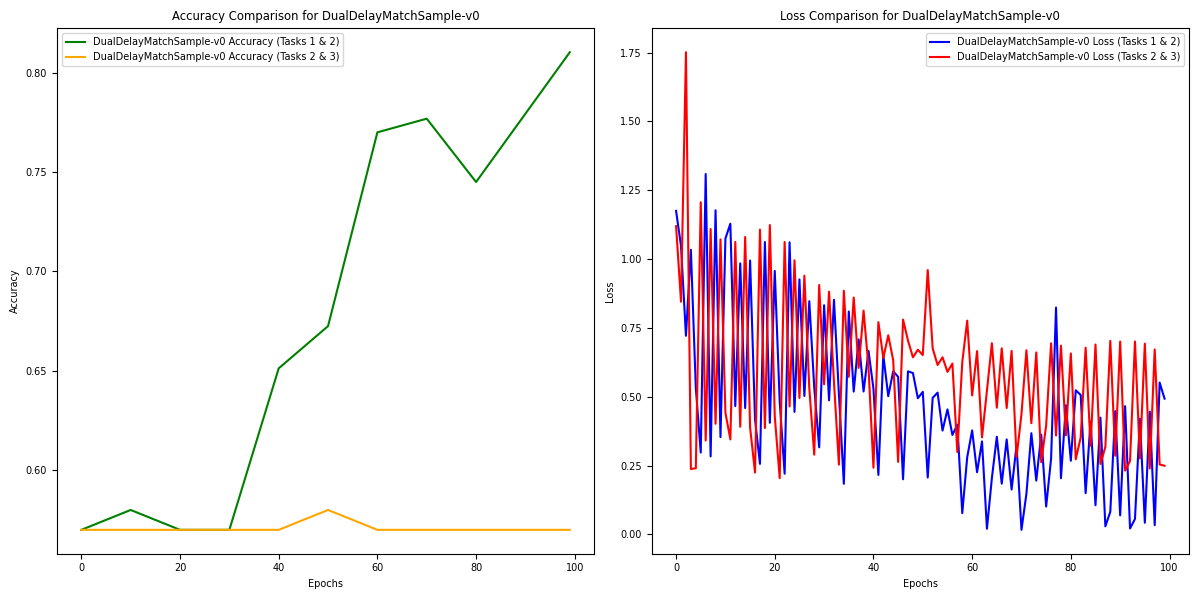

In [19]:
from scipy.interpolate import interp1d
import numpy as np
plt.rcParams['font.family'] = 'DejaVu Sans'


def evaluate_model(model, dataset, input_size, task_id=None):
    correct_choices = 0
    total_choices = 0

    for _ in range(100):
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()

        # Pad inputs to the correct size
        inputs = pad_inputs(inputs, input_size)

        if task_id is not None:
            outputs = model(inputs, task_id)  # Multitask model
        else:
            outputs, _ = model(inputs)  # Single-task model

        predictions = torch.argmax(outputs[-1], dim=1)
        last_labels = labels[-1]
        correct_choices += (predictions == last_labels).sum().item()
        total_choices += predictions.size(0)

    return correct_choices / total_choices


# Task Preparation
def prepare_task(task_name, dt=20, batch_size=16, seq_len=100):
    kwargs = {'dt': dt}
    dataset = ngym.Dataset(task_name, env_kwargs=kwargs, batch_size=batch_size, seq_len=seq_len)
    env = dataset.env
    input_size = env.observation_space.shape[0]
    output_size = env.action_space.n
    return dataset, input_size, output_size

# Define Multi-Task RNN
class MultiTaskRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_sizes):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size)
        self.fcs = nn.ModuleList([nn.Linear(hidden_size, output_size) for output_size in output_sizes])

    def forward(self, x, task_id):
        rnn_output, _ = self.lstm(x)
        out = self.fcs[task_id - 1](rnn_output)
        return out


def train_multitask_model(model, datasets, epochs, input_size):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    losses, accuracies = {1: [], 2: []}, {1: [], 2: []}
    for epoch in range(epochs):
        for task_id, dataset in datasets.items():
            inputs, labels = dataset()
            inputs = torch.from_numpy(inputs).float()
            labels = torch.from_numpy(labels.flatten()).long()
            inputs = pad_inputs(inputs, input_size)
            optimizer.zero_grad()
            outputs = model(inputs, task_id)
            outputs = outputs.view(-1, model.fcs[task_id - 1].out_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses[task_id].append(loss.item())
            if epoch % 10 == 0:
                accuracy = evaluate_model(model, dataset, input_size, task_id)
                accuracies[task_id].append(accuracy)
                print(f"Epoch {epoch + 1}, Task {task_id}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

    return losses, accuracies



def pad_inputs(inputs, target_size):
    pad_size = target_size - inputs.shape[-1]
    if pad_size > 0:
        padding = torch.zeros(inputs.shape[0], inputs.shape[1], pad_size)
        inputs = torch.cat((inputs, padding), dim=-1)
    return inputs





def common_task_results_plotting(multitask_results1, multitask_results2, task_name, epochs):

    plt.figure(figsize=(12, 6))

    x = np.arange(0, epochs, 10)
    full_x = np.arange(0, epochs, 1)
    def interpolate_data(y, label):
      #Ensure that all datasets have the same number of points for plotting, even if the input data has fewer data points. Uses interp1d (linear interpolation) from scipy.interpolate to fill in missing points."
        if len(x) != len(y):
            print(f"Length mismatch for {label}. Adjusting.")
            x_actual = np.linspace(0, epochs, len(y))
            return interp1d(x_actual, y, kind='linear', fill_value="extrapolate")(full_x)
        return interp1d(x, y, kind='linear', fill_value="extrapolate")(full_x)

    # Accuracy Interpolation
    acc_1= multitask_results1['accuracies'][2]
    acc_2 = multitask_results2['accuracies'][1]
    interpolated_acc_1 = interpolate_data(acc_1, "Accuracy (Tasks 1 & 2)")
    interpolated_acc_2 = interpolate_data(acc_2, "Accuracy (Tasks 2 & 3)")

    # Loss Interpolation
    loss_1 = multitask_results1['losses'][2]
    loss_2 = multitask_results2['losses'][1]
    interpolated_loss_1 = interpolate_data(loss_1, "Loss (Tasks 1 & 2)")
    interpolated_loss_2 = interpolate_data(loss_2, "Loss (Tasks 2 & 3)")

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(full_x, interpolated_acc_1, label=f"{task_name} Accuracy (Tasks 1 & 2)", linestyle="-", color="green")
    plt.plot(full_x, interpolated_acc_2, label=f"{task_name} Accuracy (Tasks 2 & 3)", linestyle="-", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy Comparison for {task_name}")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(full_x, interpolated_loss_1, label=f"{task_name} Loss (Tasks 1 & 2)", linestyle="-", color="blue")
    plt.plot(full_x, interpolated_loss_2, label=f"{task_name} Loss (Tasks 2 & 3)", linestyle="-", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Comparison for {task_name}")
    plt.legend()

    plt.tight_layout()
    plt.show()


########## MAIN EXECUTION ############
task1 = 'DelayMatchSample-v0'
task2 = 'DualDelayMatchSample-v0'
task3 = 'ContextDecisionMaking-v0'

# Prepare datasets
dataset1, input_size1, output_size1 = prepare_task(task1)
dataset2, input_size2, output_size2 = prepare_task(task2)
dataset3, input_size3, output_size3 = prepare_task(task3)

max_input_size = max(input_size1, input_size2, input_size3)

# Multitask training for Tasks 1 & 2
multi_task_model_t1_t2 = MultiTaskRNN(max_input_size, 128, [output_size1, output_size2])
multitask_lossest1_t2, multitask_accuraciest1_t2 = train_multitask_model(
    multi_task_model_t1_t2, {1: dataset1, 2: dataset2}, epochs=100, input_size=max_input_size
)

# Multitask training for Tasks 2 & 3
multi_task_model_t2_t3 = MultiTaskRNN(max_input_size, 128, [output_size2, output_size3])
multitask_lossest2_t3, multitask_accuraciest2_t3 = train_multitask_model(
    multi_task_model_t2_t3, {1: dataset2, 2: dataset3}, epochs=100, input_size=max_input_size
)

# Plot accuracy comparison for the common task (DualDelayMatchSample-v0)
common_task_results_plotting(
    {'losses': multitask_lossest1_t2, 'accuracies': multitask_accuraciest1_t2},
    {'losses': multitask_lossest2_t3, 'accuracies': multitask_accuraciest2_t3},
    "DualDelayMatchSample-v0",
    epochs=100
)
